In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
from numpy import genfromtxt
import torch
from deepc_hunt.dynamics import AffineDynamics
from deepc_hunt import DeePC, Trainer
from deepc_hunt.utils import tensor2np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
A = torch.Tensor([[1, 0.01], # A - State-space matrix
                  [0, 1]])
B = torch.Tensor([[0],[0.01]])
env = AffineDynamics(A=A, B=B).to(device)

In [3]:
n = 2 # n = number of states
m = 1 # m = number of inputs
p = 2 # p = number of output
q = m+p # q = number of i/o variables
Tini = 4 # Past time horizon
Tf = 10 # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1    

### Data Collection

In [4]:
x = torch.randn(2,)*0.1
yT = np.array([])
uT = np.array([])

for i in range(T):
    u = torch.rand((1,))*0.1
    uT = np.append(uT, tensor2np(u))
    x = A@x + B@u
    yT = np.append(yT, tensor2np(x))

print(f'T : {T}, yT : {yT.shape}, uT : {uT.shape}')
np.savetxt('data/integrator_ud.csv', uT, delimiter=',')
np.savetxt('data/integrator_yd.csv', yT, delimiter=',')

T : 31, yT : (62,), uT : (31,)


### Load Data

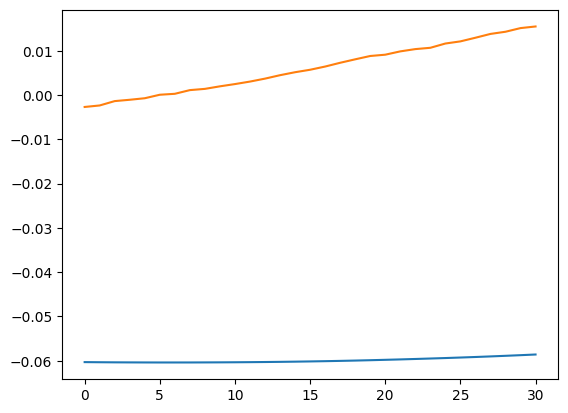

In [5]:
ud = genfromtxt('data/integrator_ud.csv', delimiter=',')
yd = genfromtxt('data/integrator_yd.csv', delimiter=',')
ud = ud.reshape(T,m)
yd = yd.reshape(T,p)

import matplotlib.pyplot as plt
plt.plot(range(T), yd)
plt.show()
# Add noise to simulate uncertainty in data
noise_std = 0.1              
yd += np.random.rand(*yd.shape)*noise_std
# ud += np.random.rand(*ud.shape)*noise_std

### Initialise Controller

In [6]:
y_constraints = np.kron(np.ones(Tf), np.array([10,10]))
u_constraints = np.kron(np.ones(Tf), np.array([5]))
q = torch.ones(p)*50
r = torch.ones(m)*2
n_batch = 20

controller = DeePC(
    ud=ud, yd=yd, N=Tf, Tini=Tini, p=p, m=m, n_batch=n_batch, device=device,
    y_constraints=y_constraints, u_constraints=u_constraints,
    stochastic_y=True, q=q, r=r
)
controller.initialise(lam_y=1e-7)
controller.to(device)

DeePC(
  (QP_layer): CvxpyLayer()
)

### Run DeePC-HUNT

In [8]:
epochs = 100
time_steps = 10

# Tune regularization params
deepc_tuner = Trainer(controller=controller, env=env)
deepc_tuner.projection.lower = 1e-7
deepc_tuner.projection.upper = 1e6
final_params = deepc_tuner.run(epochs=epochs, time_steps=time_steps)

  0%|                                                                       | 0/100 [00:00<?, ?it/s]/Users/michaelcummins/DeePC-HUNT/deepc_hunt/utils.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  Ct += (Y[i,j,:].T @ Q @ Y[i,j,:] + U[i,j,:].T @ R @ U[i,j,:]).reshape(1)
Loss = 90.4371, lam_y : 0.518, :  35%|██████████▏                  | 35/100 [00:44<01:23,  1.28s/it]

### Test Controller

In [23]:
from deepc_hunt.utils import sample_initial_signal

u_ini, y_ini = sample_initial_signal(
    Tini=Tini,
    p=p,
    m=m,
    batch=1,
    ud=controller.ud,
    yd=controller.yd
)

controller.initialise(lam_y=1e-6)
print(y_ini)
yT = [y_ini[:,-p:]]
for i in range(40):
    u = controller(y_ini=y_ini, u_ini=u_ini)
    y = env(yT[i], u)

tensor([[ 0.0315,  0.0874, -0.0231,  0.0115, -0.0472,  0.0321, -0.0355,  0.0564],
        [ 0.0308,  0.0097, -0.0312,  0.0319,  0.0315,  0.0874, -0.0231,  0.0115],
        [ 0.0086,  0.0043, -0.0364,  0.0847,  0.0355,  0.0231,  0.0006,  0.0107],
        [-0.0162,  0.0273,  0.0308,  0.0097, -0.0312,  0.0319,  0.0315,  0.0874],
        [-0.0135,  0.0838, -0.0348,  0.0225,  0.0274,  0.0842,  0.0353,  0.0433]])
